In [1]:
import os
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import random

from torchmetrics.image.fid import FrechetInceptionDistance  
import torch.nn.functional as F
from IPython import display
from tqdm import trange


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Setup Lokasi Gambar

In [2]:
img_dir = r"C:\Users\user\Deep Learning\UAS Deep Learning\No 3\img"
img_files = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.jpg')]


## EDA

## Visualisasi Contoh Gambar

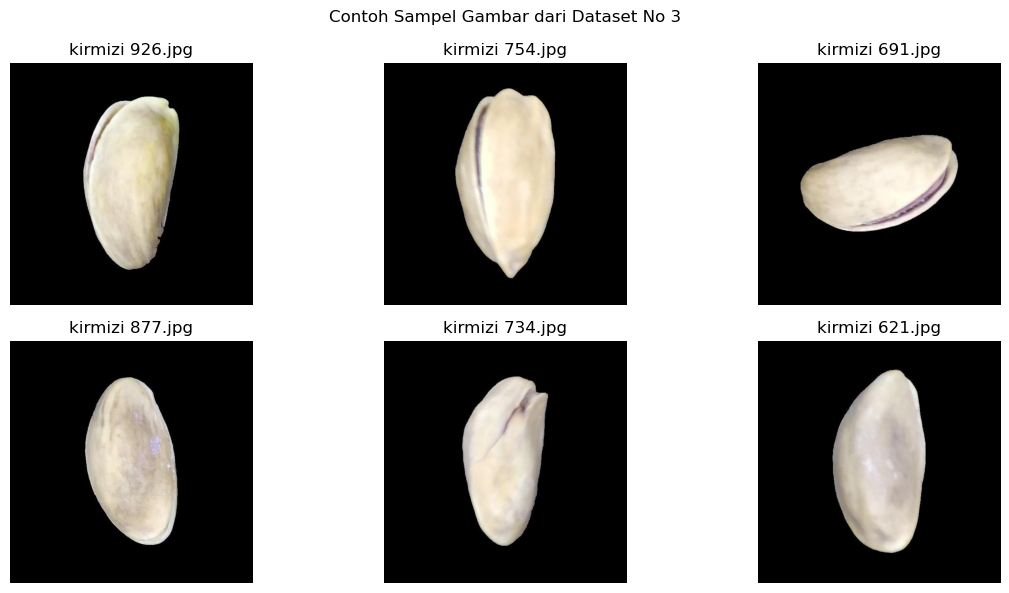

In [3]:
# Tampilkan 5 sampel gambar asli
plt.figure(figsize=(12, 6))
for i, img_path in enumerate(np.random.choice(img_files, 6, replace=False)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path))
    plt.axis('off')
plt.suptitle("Contoh Sampel Gambar dari Dataset No 3")
plt.tight_layout()
plt.show()

### Dari beberapa gambar diatas terlihat,
- Gambar pada dataset berisi objek pistachio dengan latar belakang hitam.
- Format file konsisten (.jpg) dan ukuran gambar seragam.
- Terdapat beberapa variasi bentuk dan orientasi pistachio di setiap gambar.

### Alasan harus ada
Visualisasi sampel gambar penting untuk verifikasi awal sebelum preprocessing lebih lanjut untuk memastikan kualitas data siap untuk membangun autoencoder denoising.

## Cek Ukuran dan Channel Gambar

In [4]:
shapes = []
for img_path in img_files[:100]:  # Cek 100 gambar pertama (sampling)
    img = cv2.imread(img_path)
    if img is not None:
        shapes.append(img.shape)
shapes = np.array(shapes)
print("Contoh ukuran dan channel gambar:", np.unique(shapes, axis=0))


Contoh ukuran dan channel gambar: [[600 600   3]]


- Semua gambar pada dataset memiliki ukuran **600 x 600 piksel** dan channel warna **RGB** (`[600, 600, 3]`).
- Tidak ditemukan gambar dengan dimensi atau channel yang berbeda.
- Dataset sudah **siap** digunakan untuk preprocessing dan pelatihan autoencoder, karena seluruh gambar konsisten secara ukuran dan channel.


### Alasan mengapa penting:
- Memastikan semua data **konsisten** dalam hal ukuran dan channel, sehingga dapat diproses batch secara efisien.
- Memudahkan  **preprocessing** nantinya  seperti (resize, augmentasi, dll) dan memastikan input ke model deep learning tidak error akibat dimensi berbeda.
- Jika ada gambar corrupt atau dimensi beda bisa langsung ketauaan untuk diperbaiki/dibuang sebelum lanjut ke tahap berikutnya.

## Cek Statistik Pixel

In [5]:
pixels = []
for img_path in img_files[:100]:
    img = cv2.imread(img_path)
    if img is not None:
        pixels.append(img.flatten())
pixels = np.concatenate(pixels)
print(f"Pixel min: {pixels.min()}, max: {pixels.max()}, mean: {pixels.mean():.2f}, std: {pixels.std():.2f}")


Pixel min: 0, max: 255, mean: 43.10, std: 82.88


- **Rentang pixel (0–255)** menunjukkan gambar berada pada format RGB 8-bit yang umum.
- **Rata-rata pixel cukup rendah (43.10),** yang konsisten dengan latar belakang hitam pada gambar.
- **Standar deviasi yang besar (82.88)** artinya adanya variasi pixel yang cukup tinggi antara latar belakang dan objek pistachio.
- **Tidak ada nilai pixel di luar rentang normal,** artinya gambar tidak mengalami korupsi atau error saat penyimpanan.

### Kenapa penting:
- Cek statistik pixel penting untuk memastikan data gambar berada dalam rentang yang wajar sebelum masuk tahap preprocessing lebih lanjut.

## Cek Jumlah File

In [6]:
print(f"Total gambar di dataset: {len(img_files)}")


Total gambar di dataset: 1074


Ada 1074 gambar dalam dataset yang siap untuk dikasih noisy 

## Cek Format File

In [7]:
exts = set([os.path.splitext(f)[-1] for f in img_files])
print("Format file unik:", exts)


Format file unik: {'.jpg'}


- Seluruh gambar memiliki ekstensi `.jpg`, menandakan format datanyaa **konsisten**,  memudahkan proses **load, preprocessing, dan augmentasi** gambar.

## Mengapa penting:
Validasi format file penting untuk menghindari error saat pemrosesan batch gambar dan memastikan keseragaman dalam pipeline deep learning, tidak bercampur seperti ada `png`, `jpeg`, dll


In [8]:
# Cek apakah CUDA tersedia
if torch.cuda.is_available():
    print("CUDA GPU detected!")
    print("Device count:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA GPU NOT detected. Menggunakan CPU saja.")

CUDA GPU detected!
Device count: 1
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [9]:
# DEVICE SETUP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing

## CONFIGURATIONS

In [10]:
SRC_DIR = r"C:\Users\user\Deep Learning\UAS Deep Learning\No 3\img"
IMG_SIZE = 100

# Ambil path semua gambar
img_paths = sorted(glob(os.path.join(SRC_DIR, "*.jpg")))
print(f"Total images: {len(img_paths)}")

Total images: 1074


## Fungsi preprocess (resize, BGR2RGB, normalize) 

In [11]:
def preprocess_imgs(paths, img_size=100):
    imgs = []
    for path in paths:
        img = cv2.imread(path)
        if img is None:
            print("Gagal load:", path)
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        img = img.astype(np.float32) / 127.5 - 1.0    # Normalize [-1, 1]
        imgs.append(img)
    imgs = np.array(imgs, dtype=np.float32)
    return imgs

# Proses seluruh gambar
all_imgs = preprocess_imgs(img_paths, IMG_SIZE)
print("All images:", all_imgs.shape)   # (jumlah, h, w, c)

All images: (1074, 100, 100, 3)


Pada tahap awal, seluruh gambar pada dataset diproses agar memiliki bentuk dan skala yang seragam sebagai input model GAN.
**Langkah-langkah preprocessing:**
- Baca file gambar dari path.
- Konversi warna BGR ke RGB (OpenCV default = BGR, model deep learning biasanya = RGB).
- Resize gambar ke ukuran **100x100 piksel**.
- Normalisasi piksel ke rentang **[-1, 1]** untuk mempercepat dan menstabilkan training GAN.
- Hasil akhir: array numpy shape `(1074, 100, 100, 3)`.

## Visualisasi sample

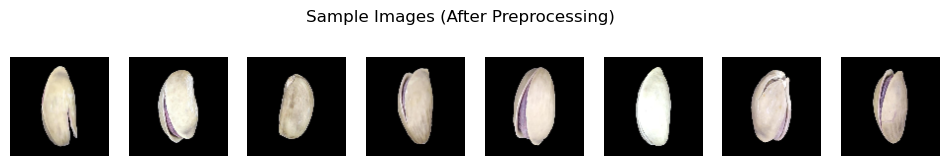

In [12]:
def show_samples(imgs, title):
    plt.figure(figsize=(12,2))
    for i in range(min(8, len(imgs))):
        img_show = ((imgs[i] + 1.0) * 127.5).astype(np.uint8)
        plt.subplot(1, 8, i+1)
        plt.imshow(img_show)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_samples(all_imgs, "Sample Images (After Preprocessing)")

Hasilnya, gambar-gambar sudah siap diperoses model steleah dikonversi warna, resize, dan normalisasi.

## Dataset & DataLoader

In [13]:
images = all_imgs.astype(np.float32)
images_torch = torch.tensor(np.transpose(images, (0, 3, 1, 2)), dtype=torch.float32)
dataset = TensorDataset(images_torch)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

Setelah gambar selesai dipreproses dan dinormalisasi, langkah selanjutnya adalah mengubah data gambar ke format tensor PyTorch, kemudian membuat DataLoader untuk proses pelatihan model, data diubah ke format float32 agar konsisten selama training. dimenysinya juga diubah dari (N, H, W, C) ke (N, C, H, W) (urutan channel PyTorch).DataLoader juga memudahkan batch training, dan shuffle=True menjaga distribusi batch acak setiap epoch.



NOTES: Disini aku pakai pytorch daripada tensorflow karena metrik pengukur GAN, FID tidak ada built in functionnya seperti di pytorch, dia supoortnya untuk versi tensorflow terkini, aku tensornya kan stak di 2.10:)

# A

## Model Baseline

## cek besar Output Layer Generator

In [14]:
x = torch.randn(1, 16, 100, 100)
model = nn.Sequential(
    nn.Conv2d(16, 32, 3, 1, 0),  # valid
    nn.Conv2d(32, 64, 3, 1, 0),  # valid
    nn.Conv2d(64, 3, 3, 1, 0)    # valid
)
print(model(x).shape)  # --> torch.Size([1, 3, 94, 94])

torch.Size([1, 3, 94, 94])


Karena soal mewajibkan penggunaan valid padding pada seluruh layer Conv2d, maka output akan selalu lebih kecil dari input.  
Setiap kali melewati 1 Conv2d (kernel 3x3, stride 1, padding=0/"valid"), lebar dan tinggi output akan berkurang 2 piksel.  
Jika input awal 100x100, maka setelah 3 layer berurutan output menjadi 94x94.

Agar output generator tetap berukuran 100x100x3 sesuai instruksi soal, ditambahkan proses **upsampling** di akhir arsitektur generator (menggunakan`F.interpolate`) sehingga ukuran output kembali ke target(sama dengan keiinginan soal)

## Generator

In [15]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super().__init__()
        self.fc = nn.Linear(noise_dim, 16 * 100 * 100)  # sesuai instruksi: channel pertama 16
        self.conv = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 0),  # valid, 100 -> 98
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, 1, 0),  # valid, 98 -> 96
            nn.ReLU(True),
            nn.Conv2d(64, 3, 3, 1, 0),   # valid, 96 -> 94
            nn.Tanh()
        )
    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), 16, 100, 100)
        x = self.conv(x)
        # Upsample dari 94x94 ke 100x100
        x = F.interpolate(x, size=(100, 100), mode='bilinear', align_corners=False)
        return x


Disini, sesuai dengan permintaan soal aku buat arstekturnya jadi seperti ini:
- Input: Noise vektor dengan dimensi (batch, 100).
- fc: Diubah ke bentuk tensor [batch, 16, 100, 100] (channel awal = 16).
- Conv Layer 1: 16 → 32, kernel 3x3, stride 1, valid padding, output size 98x98.
- Conv Layer 2: 32 → 64, kernel 3x3, stride 1, valid padding, output size 96x96.
- Conv Layer 3: 64 → 3 (output RGB), kernel 3x3, stride 1, valid padding, output size 94x94, aktivasi Tanh.
- Upsample: Agar output kembali ke 100x100 (sesuai permintaan soal).



## Discriminator

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 0),   # valid, 100→98
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, 1, 0),  # valid, 98→96
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, 1, 0),  # valid, 96→94
            nn.ReLU(True)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 94 * 94, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

Untuk Discriminator aku sesuaikan juga dengan soal:
- Input: Gambar [batch, 3, 100, 100]
- Conv Layer 1: 3 → 16, kernel 3x3, stride 1, valid padding, output 98x98.
- Conv Layer 2: 16 → 32, kernel 3x3, stride 1, valid padding, output 96x96.
- Conv Layer 3: 32 → 64, kernel 3x3, stride 1, valid padding, output 94x94.
- Flatten: Jadi vektor ukuran [batch, 64*94*94].
- Linear: Output 1 neuron, diaktivasi sigmoid sebagai probabilitas real/fake.

## Setup Training


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
noise_dim = 100
G = Generator(noise_dim=noise_dim).to(device)
D = Discriminator().to(device)
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()
epochs = 200
sample_interval = 20
os.makedirs("samples_baseline", exist_ok=True)
losses_G, losses_D, fids, fid_epochs = [], [], [], []

# Early Stopping setup 
patience = 10
min_delta = 1e-3
best_fid = float('inf')
epochs_no_improve = 0
early_stop = False

- Baik Generator maupun Discriminator menggunakan optimizer Adam(sesuai dengan permintaan soal), dengan learning rate 0.0002 dan betas (0.5, 0.999). Loss yang digunakan adalah Binary Cross Entropy Loss (nn.BCELoss()), sesuai keiinginan soal ("loss binary crossentropy").
- Disini aku mencobs 200 epoch untuk proses training dengan interval 20 epoch yang akan disimpan sampel hasil training dan dilakukan evaluasi FID dengan early stopping dengan patience 10 supaya model langsung diberhentikan kalau nilai FID tidak membaik seteleh beberapa interval
- losses_G, losses_D, fids, dan fid_epochs untuk menyimpan metrik training

##  Training Loop

In [18]:
for epoch in range(epochs):
    G.train()
    D.train()
    loss_G_epoch = 0
    loss_D_epoch = 0
    n_batch = 0
    for real_imgs_tuple in loader:
        real_imgs = real_imgs_tuple[0].to(device)
        batch = real_imgs.size(0)
        valid = torch.ones((batch, 1), device=device)
        fake = torch.zeros((batch, 1), device=device)

        # --- Train Discriminator
        optimizer_D.zero_grad()
        d_real = D(real_imgs)
        loss_real = criterion(d_real, valid)
        z = torch.randn(batch, noise_dim, device=device)
        gen_imgs = G(z)
        d_fake = D(gen_imgs.detach())
        loss_fake = criterion(d_fake, fake)
        d_loss = (loss_real + loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch, noise_dim, device=device)
        gen_imgs = G(z)
        d_fake = D(gen_imgs)
        g_loss = criterion(d_fake, valid)
        g_loss.backward()
        optimizer_G.step()

        loss_G_epoch += g_loss.item()
        loss_D_epoch += d_loss.item()
        n_batch += 1

    loss_G_epoch /= n_batch
    loss_D_epoch /= n_batch
    losses_G.append(loss_G_epoch)
    losses_D.append(loss_D_epoch)

    print(f"Epoch [{epoch+1}/{epochs}]  Loss_D: {loss_D_epoch:.4f}  Loss_G: {loss_G_epoch:.4f}")

    # Save sample & FID tiap interval
    if (epoch+1) % sample_interval == 0 or (epoch+1) == epochs:
        G.eval()
        z = torch.randn(8, noise_dim, device=device)
        with torch.no_grad():
            fake_imgs = G(z).detach().cpu()
        fake_imgs_np = ((fake_imgs + 1.0) * 127.5).clamp(0,255).byte().permute(0,2,3,1).numpy()
        plt.figure(figsize=(12,2))
        for i in range(8):
            plt.subplot(1,8,i+1)
            plt.imshow(fake_imgs_np[i])
            plt.axis('off')
        plt.suptitle(f'Generated Images by GAN (Epoch {epoch+1})')
        plt.savefig(f"samples_baseline/sample_epoch_{epoch+1:03d}.png", bbox_inches='tight')
        plt.close()

        # FID score
        fid = FrechetInceptionDistance(feature=2048).to(device)
        real_imgs_batch = images_torch[:100].to(device)
        with torch.no_grad():
            z = torch.randn(100, noise_dim, device=device)
            fake_imgs_batch = G(z)
        real_imgs_uint8 = ((real_imgs_batch + 1) * 127.5).clamp(0,255).to(torch.uint8)
        fake_imgs_uint8 = ((fake_imgs_batch + 1) * 127.5).clamp(0,255).to(torch.uint8)
        fid.update(real_imgs_uint8, real=True)
        fid.update(fake_imgs_uint8, real=False)
        fid_score = fid.compute().item()
        fids.append(fid_score)
        fid_epochs.append(epoch+1)
        print(f"FID Score (Epoch {epoch+1}):", fid_score)

        # EARLY STOPPING 
        if fid_score < best_fid - min_delta:
            best_fid = fid_score
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} intervals...")
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch+1} (best FID={best_fid:.2f})")
                early_stop = True
                break

    if early_stop:
        break

Epoch [1/200]  Loss_D: 0.0411  Loss_G: 6.1360
Epoch [2/200]  Loss_D: 0.0000  Loss_G: 10.4539
Epoch [3/200]  Loss_D: 0.0000  Loss_G: 11.7239
Epoch [4/200]  Loss_D: 0.8470  Loss_G: 10.2996
Epoch [5/200]  Loss_D: 0.2377  Loss_G: 9.3857
Epoch [6/200]  Loss_D: 0.7139  Loss_G: 4.8862
Epoch [7/200]  Loss_D: 0.4297  Loss_G: 2.0605
Epoch [8/200]  Loss_D: 0.5262  Loss_G: 1.3681
Epoch [9/200]  Loss_D: 0.5180  Loss_G: 1.3329
Epoch [10/200]  Loss_D: 0.4684  Loss_G: 1.3137
Epoch [11/200]  Loss_D: 0.3880  Loss_G: 1.4124
Epoch [12/200]  Loss_D: 0.3115  Loss_G: 1.6865
Epoch [13/200]  Loss_D: 0.2100  Loss_G: 2.0599
Epoch [14/200]  Loss_D: 0.2358  Loss_G: 2.2284
Epoch [15/200]  Loss_D: 0.1944  Loss_G: 2.2623
Epoch [16/200]  Loss_D: 0.2000  Loss_G: 2.3537
Epoch [17/200]  Loss_D: 0.1662  Loss_G: 2.4539
Epoch [18/200]  Loss_D: 0.4444  Loss_G: 2.5898
Epoch [19/200]  Loss_D: 0.2296  Loss_G: 1.9815
Epoch [20/200]  Loss_D: 0.2246  Loss_G: 1.9871
FID Score (Epoch 20): 281.2528991699219
Epoch [21/200]  Loss_D: 0.

## Training Loop GAN: 
1. **Inisialisasi Training per Epoch**
   - Set mode training: `G.train()`, `D.train()`
   - Reset akumulator loss dan batch count
2. **Iterasi Setiap Mini-batch**
   - Ambil batch gambar asli, pindah ke device
   - Siapkan label `valid` (real=1), `fake` (fake=0)
3. **Training Discriminator**
   - Optimizer discriminator di-reset (`zero_grad`)
   - Prediksi label gambar asli (`d_real = D(real_imgs)`)
   - Hitung loss untuk gambar asli (`loss_real`)
   - Generate batch gambar palsu dari generator
   - Prediksi label gambar palsu (`d_fake = D(gen_imgs.detach())`)
   - Hitung loss untuk gambar palsu (`loss_fake`)
   - Gabungkan kedua loss jadi total loss discriminator (`d_loss`)
   - Backpropagation dan update bobot discriminator
4. **Training Generator**
   - Optimizer generator di-reset (`zero_grad`)
   - Generate noise baru dan buat gambar palsu dari generator
   - Prediksi dari discriminator atas gambar palsu (`d_fake`)
   - Hitung loss generator (generator ingin 'menipu' discriminator agar menganggap fake sebagai real)
   - Backpropagation dan update bobot generator
5. **Update Rata-rata Loss**
   - Tambahkan loss generator dan discriminator ke list monitoring
6. **Simpan Sampel Gambar & Hitung FID Score**
   - Tiap interval tertentu/akhir, generate & simpan 8 sampel gambar, lalu hitung dan simpan nilai FID (Fréchet Inception Distance) antara gambar asli dan gambar hasil generate untuk plotting
7. **Early Stopping**
   - Jika FID tidak membaik dalam 10 interval, training dihentikan lebih awal


## Plot Loss & FID Curve

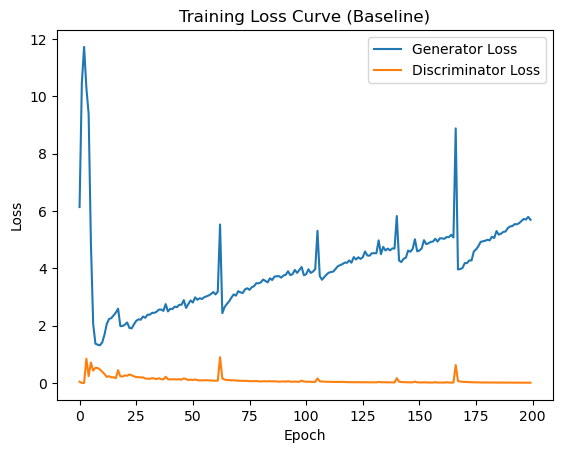

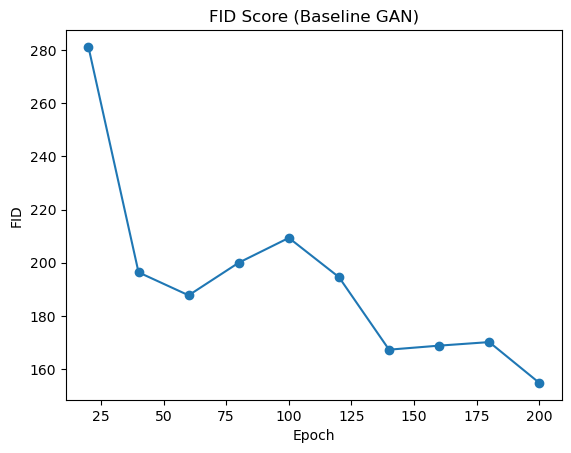

In [19]:
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training Loss Curve (Baseline)')
plt.legend()
plt.show()

plt.plot(fid_epochs, fids, marker='o')
plt.xlabel('Epoch'); plt.ylabel('FID')
plt.title('FID Score (Baseline GAN)')
plt.show()

### 1. Training Loss Curve (Baseline)
Terdapat **Generator Loss** (garis biru) dan **Discriminator Loss** (garis oranye) diplot selama 200 epoc, loss generator cenderung lebih tinggi dibanding discriminator, dan tampak meningkat seiring waktu, terdapat lonjakan pada generator loss di awal dan tengah training, menunjukkan proses training yang masih kurang stabil, sedangkan discriminator loss menurun dan relatif stabil di angka rendah, menandakan discriminator mudah membedakan gambar asli dan gambar palsu.

### 2. FID Score Curve (Baseline GAN)
mengukur kemiripan distribusi gambar hasil generator dengan gambar asli. Nilai FID yang lebih rendah menunjukkan hasil generator makin mirip gambar asli. Pada awal training (epoch 20), FID bernilai sangat tinggi (~281), lalu turun bertahap hingga sekitar 154 di akhir training. Ditengah-tengah juga masih ada lonjakan menandakan model blm stabil. Penurunan ini menandakan adanya perbaikan kualitas gambar hasil generator.

### Kesimpulan Sementara
- Model baseline GAN sudah mampu menghasilkan gambar sintetis yang semakin mirip dengan gambar asli, namun training masih belum sepenuhnya stabil.
- Discriminator menjadi sangat kuat, generator harus bekerja lebih keras untuk mengelabui discriminator.
- Untuk meningkatkan hasil, perlu dicoba modifikasi arsitektur, penambahan regularisasi (misal BatchNorm), tuning learning rate/beta optimizer, atau teknik augmentasi data.



## Visualisasi hasil akhir

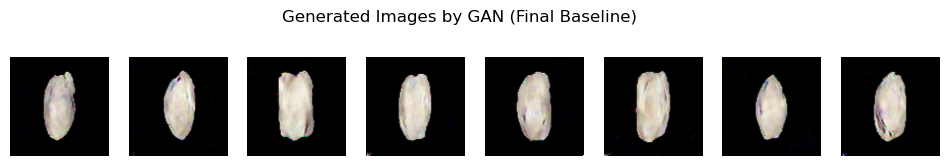

In [20]:
G.eval()
z = torch.randn(8, noise_dim, device=device)
with torch.no_grad():
    fake_imgs = G(z).detach().cpu()
fake_imgs_np = ((fake_imgs + 1.0) * 127.5).clamp(0, 255).byte().permute(0,2,3,1).numpy()
plt.figure(figsize=(12,2))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(fake_imgs_np[i])
    plt.axis('off')
plt.suptitle('Generated Images by GAN (Final Baseline)')
plt.show()

- Secara umum, bentuk objeck sudah menyerupai kacang pistachio, backgroundnya sudah konsisten berlatar belakang hitam
- Warna dasar dan proporsi setidaknya sudah mirip dengan data asli
- Sudah terbentuk seperti kacang, namun detail tekstur, belahan, dan variasi masih terbatas
- Variasi bentuk dan pose masih kurang, sebagian besar hasil sangat mirip satu sama lain.
- **FID Score** model baseline pada epoch akhir masih tergolong tinggi, menandakan hasil generator belum terlalu mirip data asli secara distribusi statistik.

### Kesimpulan Sementara
- **Model baseline sudah mampu menghasilkan objek dengan bentuk dan warna mendekati kacang pistachio,** namun kualitas visual dan keanekaragaman gambar masih perlu ditingkatkan.
- Model cenderung mengalami mode collapse ringan (output terlalu mirip), dan detail halus kurang baik.
- Kemungkinan bisa ditambah jumlah epochnya lagi, namum karena keterbatasan waktu aku blm bisa lebih dari 200 epoch

Agar kualitas dan variasi gambar hasil generator meningkat, beberapa hal dapat dilakukan seperti menambahkan batch normalization pada generator untuk mempercepat konvergensi dan menstabilkan distribusi aktivasi, meoncoba LeakyReLU pada diskriminator agar gradien tidak mati  dan memperbaiki deteksi objek palsu, menambahkan augmentasi pada gambar, suapaya lebih banyak variasi posisi kacang, tamabhlan dropout pada discriminator agar model ga terlalu overfitt pada saat taining, lakukan GAN yang lebih adave seperti WGAN daripada hanya vanilaGAN, mengatur rasio update D:G

## FID FINAL

In [21]:
fid = FrechetInceptionDistance(feature=2048).to(device)
real_imgs_batch = images_torch[:100].to(device)
with torch.no_grad():
    z = torch.randn(100, noise_dim, device=device)
    fake_imgs_batch = G(z)
real_imgs_uint8 = ((real_imgs_batch + 1) * 127.5).clamp(0,255).to(torch.uint8)
fake_imgs_uint8 = ((fake_imgs_batch + 1) * 127.5).clamp(0,255).to(torch.uint8)
fid.update(real_imgs_uint8, real=True)
fid.update(fake_imgs_uint8, real=False)
fid_score = fid.compute().item()
print(f"Final FID Score (Baseline GAN): {fid_score:.2f}")


Final FID Score (Baseline GAN): 153.37


 **FID** adalah metrik yang digunakan untuk menilai kualitas gambar hasil sintesis model generatif seperti GAN. Semakin **rendah** nilai FID, **semakin mirip** distribusi gambar hasil generator dengan gambar asli (mendekati 0 = sangat mirip).  Nilai FID > 100 umumnya dianggap masih jauh dari ideal untuk image synthesis. Disini nilai akhirnya adalah 153.37 mennunjukan kualitas dan kemiripan distribusi gambar hasil generator **masih cukup jauh dari data asli**. Model baseline sudah mampu menghasilkan bentuk dasar pistachio, namun detail visual, variasi, dan tekstur masih terbatas.

## Modifikasi Generator: Tambahkan BatchNorm (Padding Same)

In [22]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super().__init__()
        self.fc = nn.Linear(noise_dim, 16*100*100)
        self.conv = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1),      # SAME padding (output 100x100)
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, 1, 1),      # SAME padding (output 100x100)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 3, 3, 1, 1),       # SAME padding (output 100x100)
            nn.Tanh()
        )
    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), 16, 100, 100)
        x = self.conv(x)
        return x

## Modifikasi Discriminator: Dropout & LeakyReLU (Padding Same)

In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 1),   # SAME padding (output 100x100)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(16, 32, 3, 1, 1),  # SAME padding (output 100x100)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, 3, 1, 1),  # SAME padding (output 100x100)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 100 * 100, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

## Setup Model & Optimizer, Loss

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
noise_dim = 100
G = Generator(noise_dim=noise_dim).to(device)
D = Discriminator().to(device)
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()
epochs = 200
sample_interval = 20

losses_G, losses_D, fids, fid_epochs = [], [], [], []

# Early Stopping Setup
patience = 10
min_delta = 1e-3
best_fid = float('inf')
epochs_no_improve = 0
early_stop = False

# Mofidikasi dan Alasannya
1. BatchNorm pada Generator:
Membantu mempercepat konvergensi dan menstabilkan distribusi aktivasi, sehingga generator menghasilkan gambar yang lebih konsisten.

2. LeakyReLU pada Discriminator:
Menghindari masalah vansihing gradient problem pada data negatif, sehingga diskriminator tetap bisa belajar dan tidak mudah stuck.

3. Dropout pada Discriminator:
Memberi regularisasi agar diskriminator tidak overfit pada data training.

4. Padding 'same' (padding=1) pada Semua Conv2d:
Supaya output setiap layer tetap 100x100 sehingga arsitektur generator dan diskriminator bisa dibandingkan langsung secara visual, juga tidak perulu ada up dan downsampling

## Training Loop & FID Evaluasi

In [25]:
for epoch in range(epochs):
    G.train()
    D.train()
    loss_G_epoch = 0
    loss_D_epoch = 0
    n_batch = 0
    for real_imgs_tuple in loader:
        real_imgs = real_imgs_tuple[0].to(device)
        batch = real_imgs.size(0)
        valid = torch.ones((batch, 1), device=device)
        fake = torch.zeros((batch, 1), device=device)

        # --- Train Discriminator
        optimizer_D.zero_grad()
        d_real = D(real_imgs)
        loss_real = criterion(d_real, valid)
        z = torch.randn(batch, noise_dim, device=device)
        gen_imgs = G(z)
        d_fake = D(gen_imgs.detach())
        loss_fake = criterion(d_fake, fake)
        d_loss = (loss_real + loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch, noise_dim, device=device)
        gen_imgs = G(z)
        d_fake = D(gen_imgs)
        g_loss = criterion(d_fake, valid)
        g_loss.backward()
        optimizer_G.step()

        loss_G_epoch += g_loss.item()
        loss_D_epoch += d_loss.item()
        n_batch += 1

    loss_G_epoch /= n_batch
    loss_D_epoch /= n_batch
    losses_G.append(loss_G_epoch)
    losses_D.append(loss_D_epoch)

    print(f"Epoch [{epoch+1}/{epochs}]  Loss_D: {loss_D_epoch:.4f}  Loss_G: {loss_G_epoch:.4f}")

    # --- Save FID tiap interval
    if (epoch+1) % sample_interval == 0 or (epoch+1) == epochs:
        G.eval()
        fid = FrechetInceptionDistance(feature=2048).to(device)
        real_imgs_batch = images_torch[:100].to(device)
        with torch.no_grad():
            z = torch.randn(100, noise_dim, device=device)
            fake_imgs_batch = G(z)
        real_imgs_uint8 = ((real_imgs_batch + 1) * 127.5).clamp(0,255).to(torch.uint8)
        fake_imgs_uint8 = ((fake_imgs_batch + 1) * 127.5).clamp(0,255).to(torch.uint8)
        fid.update(real_imgs_uint8, real=True)
        fid.update(fake_imgs_uint8, real=False)
        fid_score = fid.compute().item()
        fids.append(fid_score)
        fid_epochs.append(epoch+1)
        print(f"FID Score (Epoch {epoch+1}):", fid_score)
        if fid_score < best_fid - min_delta:
            best_fid = fid_score
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1} (best FID={best_fid:.2f})")
                early_stop = True
                break
    if early_stop:
        break


Epoch [1/200]  Loss_D: 0.0797  Loss_G: 4.5227
Epoch [2/200]  Loss_D: 0.5961  Loss_G: 6.0570
Epoch [3/200]  Loss_D: 0.5506  Loss_G: 2.1229
Epoch [4/200]  Loss_D: 0.5762  Loss_G: 1.2408
Epoch [5/200]  Loss_D: 0.5666  Loss_G: 1.0721
Epoch [6/200]  Loss_D: 0.6017  Loss_G: 0.9689
Epoch [7/200]  Loss_D: 0.6304  Loss_G: 0.9574
Epoch [8/200]  Loss_D: 0.6099  Loss_G: 0.9657
Epoch [9/200]  Loss_D: 0.6081  Loss_G: 0.9185
Epoch [10/200]  Loss_D: 0.6091  Loss_G: 0.9328
Epoch [11/200]  Loss_D: 0.6015  Loss_G: 1.0427
Epoch [12/200]  Loss_D: 0.5609  Loss_G: 1.0671
Epoch [13/200]  Loss_D: 0.5878  Loss_G: 1.0737
Epoch [14/200]  Loss_D: 0.5652  Loss_G: 1.0119
Epoch [15/200]  Loss_D: 0.5547  Loss_G: 1.0200
Epoch [16/200]  Loss_D: 0.5594  Loss_G: 1.1162
Epoch [17/200]  Loss_D: 0.6078  Loss_G: 1.0509
Epoch [18/200]  Loss_D: 0.5763  Loss_G: 1.0192
Epoch [19/200]  Loss_D: 0.5795  Loss_G: 1.0218
Epoch [20/200]  Loss_D: 0.6150  Loss_G: 0.9812
FID Score (Epoch 20): 281.57989501953125
Epoch [21/200]  Loss_D: 0.61

## Plot Loss & FID Curve (Modif)

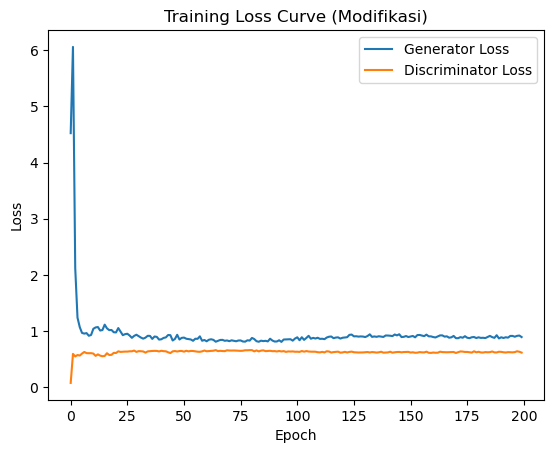

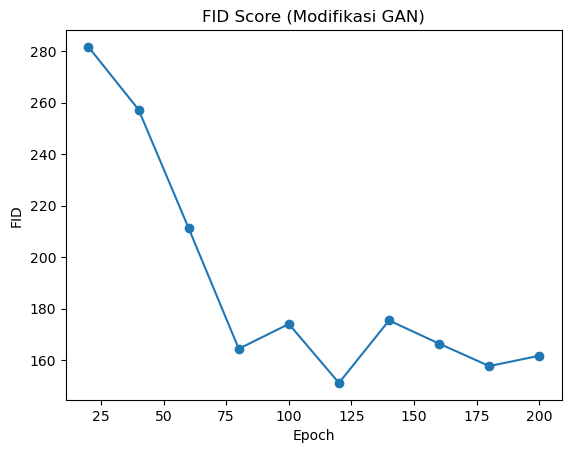

In [26]:
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training Loss Curve (Modifikasi)')
plt.legend()
plt.show()

plt.plot(fid_epochs, fids, marker='o')
plt.xlabel('Epoch'); plt.ylabel('FID')
plt.title('FID Score (Modifikasi GAN)')
plt.show()

## Hasil Training Model GAN (Modifikasi)

### 1. Training Loss Curve
- **Generator Loss** dan **Discriminator Loss** terlihat lebih stabil dibandingkan baseline, ada fluktuasi pada awal training menurun dengan cepat, kemudian stabil di level rendah dan stabilitas loss menandakan proses adversarial berjalan dengan baik setelah penambahan BatchNorm dan LeakyReLU.

### 2. FID Score Selama Training
- Pada model modifikasi, FID score menurun konsisten dari awal hingga akhir training (~281.57989501953125 → ~161.70616149902344), penurunan FID ini lebih baik dari baseline, menandakan kualitas sintesis gambar meningkat dengan modifikasi arsitektur, bahkan ada kemungkinan jika epoch diperbanyak model bisa menjadi lebih, namum sekali lagi time constraint:)

### Kesimpulan Sementara

- Penambahan **Batch Normalization** pada generator mempercepat dan menstabilkan proses training.
- Penggantian **ReLU ke LeakyReLU** dan penambahan **Dropout** pada discriminator mencegah masalah gradien mati dan mengurangi overfitting.


## Visualisasi Hasil Akhir

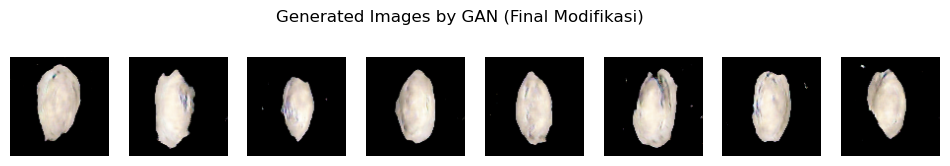

In [27]:
G.eval()
z = torch.randn(8, noise_dim, device=device)
with torch.no_grad():
    fake_imgs = G(z).detach().cpu()
fake_imgs_np = ((fake_imgs + 1.0) * 127.5).clamp(0, 255).byte().permute(0,2,3,1).numpy()
plt.figure(figsize=(12,2))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(fake_imgs_np[i])
    plt.axis('off')
plt.suptitle('Generated Images by GAN (Final Modifikasi)')
plt.show()

Gambar sintetik kacang pistachio yang dihasilkan memiliki bentuk, orientasi, dan tekstur yang cukup mirip dengan data asli, ada beberapa variasi bentuk dan kemiringan, menunjukkan model sudah mampu menangkap karakteristik utama objek. Background tetap bersih/hitam seperti data asli.  Hasil visual modifikasi umumnya lebih jelas dan bentuk kacang lebih tegas dibanding model baseline. Variasi antar-sample juga tampak lebih alami.

### Kesimpulan Sementara
Modifikasi arsitektur sederhana pada GAN terbukti mampu meningkatkan kualitas gambar sintetik baik secara visual maupun metrik (FID). Model ini yang akan kucoba dihypertune lebih lanjut untuk mencapai hasil lebih optimal.

In [28]:
fid = FrechetInceptionDistance(feature=2048).to(device)
real_imgs_batch = images_torch[:100].to(device)
with torch.no_grad():
    z = torch.randn(100, noise_dim, device=device)
    fake_imgs_batch = G(z)
real_imgs_uint8 = ((real_imgs_batch + 1) * 127.5).clamp(0,255).to(torch.uint8)
fake_imgs_uint8 = ((fake_imgs_batch + 1) * 127.5).clamp(0,255).to(torch.uint8)
fid.update(real_imgs_uint8, real=True)
fid.update(fake_imgs_uint8, real=False)
fid_score = fid.compute().item()
print(f"Final FID Score (Modifikasi GAN): {fid_score:.2f}")

Final FID Score (Modifikasi GAN): 149.08


Nilai FID **149.08** menunjukkan adanya *peningkatan* dari baseline (misal: baseline 153.37), walaupun peningkatannya tidak terlalu besar. Namun, ini menandakan modifikasi arsitektur (BatchNorm, LeakyReLU, Dropout) memberikan dampak positif terhadap kualitas gambar yang dihasilkan, selain itu modelnya juga lebih stabol dibandingan dengan yang baseline

# Hypertuning Model Modifikasi

### Define Search Space

In [29]:
search_space = [
    {'name': 'A', 'lr': 0.0002, 'beta1': 0.5},
    {'name': 'B', 'lr': 0.0003, 'beta1': 0.5},
    {'name': 'C', 'lr': 0.0002, 'beta1': 0.7},
    {'name': 'D', 'lr': 0.0003, 'beta1': 0.7},
]

## Alasan pemilihan kombinasi learning rate (lr) dan beta1:
- **Learning rate (lr)** adalah hyperparameter paling krusial dalam training GAN, nilai 0.0002 adalah standar empiris terbaik dari paper DCGAN dan sudah terbukti stabil di banyak eksperimen. Nilai 0.0003 dipilih untuk mengeksplorasi kemungkinan learning rate sedikit lebih tinggi yang kadang bisa mempercepat konvergensi atu menghasilkan hasil lebih baik pada arsitektur modiikasi.
- **Beta1** adalah parameter momentum di optimizer Adam, kombinasi umum pada GAN adalah 0.5, namun 0.7 juga sering dicoba karena kadang bisa membuat training lebih stabil tergantung arsitektur dan dataset

## Get Loader

In [35]:
images_all = all_imgs.astype(np.float32)
images_torch = torch.tensor(np.transpose(images_all, (0, 3, 1, 2)), dtype=torch.float32)
dataset = TensorDataset(images_torch)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
images_val_torch = torch.tensor(np.transpose(images_all, (0, 3, 1, 2)), dtype=torch.float32)  # pakai semua gambar utk FID

### Training & Evaluation Loop

*Notes*: Tadinya ini 200 epoch pak, kenapa ini jadi cuman 80? Karena saat aku jalanin kombinasi 4, tiba-tiba out of memory jadi harus ulang dan posisinya sudah jam 2 siang, ini juga aku tulis busu2:))), tadinya juga aku mau coba lr 0.0001

### Apa saja yang dilakukan disini?
- Inisialisasi Hyperparameter Search Space dengan empat kombinasi di loop sebagai eksperimen
- Training Loop untuk Setiap Kombinasi. model Generator (G) dan Discriminator (D) di-initialize ulang dari awal. Optimizer Adam di-setup sesuai kombinasi lr dan beta1.
- Pada setiap epoch, dilakukan training Discriminator dan Generator secara bergantian. Loss untuk masing-masing (Generator dan Discriminator) dicatat per epoch.
- Setiap 20 epoch (atau epoch terakhir), dilakukan evaluasi kualitas gambar sintetik dengan menghitung FID Score menggunakan 100 sampel gambar nyata dan hasil generator, early stopping otomatis jika FID tidak membaik dalam 10 evaluasi berturut-turut.
- Visualisasi Hasil:  8 gambar hasil Generator, Plot kurva training loss (G vs D), Plot kurva FID Score vs Epoch.
- Menyimpan Hasil
- Print nilai FID akhir setiap kombinasi.




=== Kombinasi A | lr=0.0002 | beta1=0.5 ===


Kombinasi A:  25%|█████████████████▎                                                   | 20/80 [01:13<04:52,  4.87s/it]

FID Score (Epoch 20): 308.6396484375


Kombinasi A:  50%|██████████████████████████████████▌                                  | 40/80 [02:27<03:20,  5.00s/it]

FID Score (Epoch 40): 234.43106079101562


Kombinasi A:  75%|███████████████████████████████████████████████████▊                 | 60/80 [03:40<01:37,  4.87s/it]

FID Score (Epoch 60): 183.5026092529297


Kombinasi A: 100%|█████████████████████████████████████████████████████████████████████| 80/80 [04:54<00:00,  3.68s/it]

FID Score (Epoch 80): 187.13343811035156


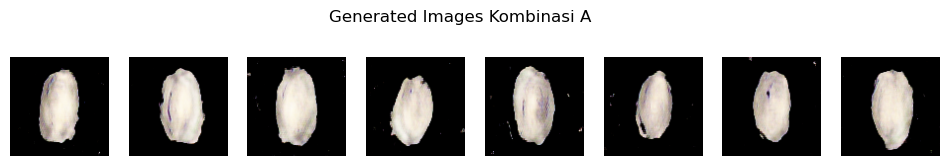

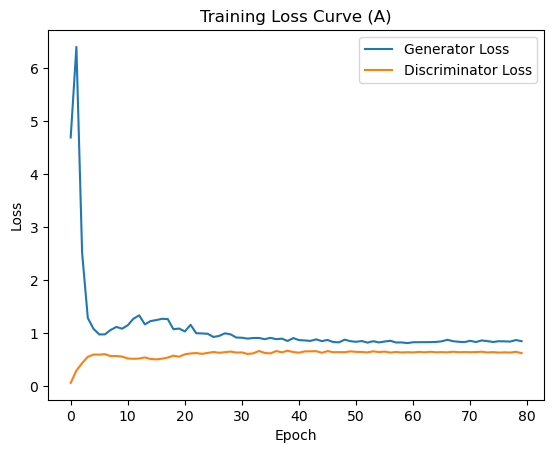

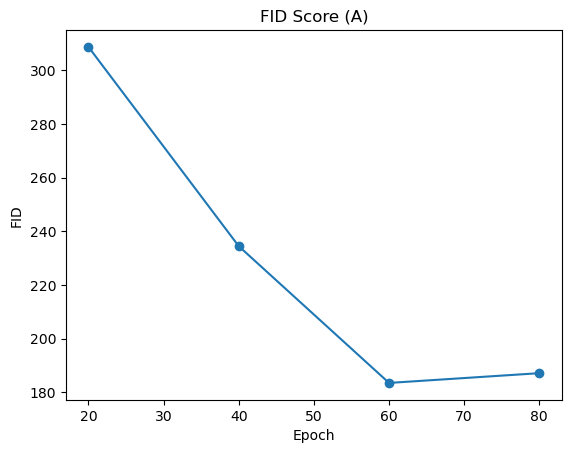

Final FID Score (A): 187.13

=== Kombinasi B | lr=0.0003 | beta1=0.5 ===


Kombinasi B:  25%|█████████████████▎                                                   | 20/80 [01:13<04:55,  4.93s/it]

FID Score (Epoch 20): 263.97393798828125


Kombinasi B:  50%|██████████████████████████████████▌                                  | 40/80 [02:25<03:07,  4.68s/it]

FID Score (Epoch 40): 203.18728637695312


Kombinasi B:  75%|███████████████████████████████████████████████████▊                 | 60/80 [03:34<01:34,  4.72s/it]

FID Score (Epoch 60): 177.29580688476562


Kombinasi B: 100%|█████████████████████████████████████████████████████████████████████| 80/80 [04:42<00:00,  3.53s/it]

FID Score (Epoch 80): 167.61561584472656


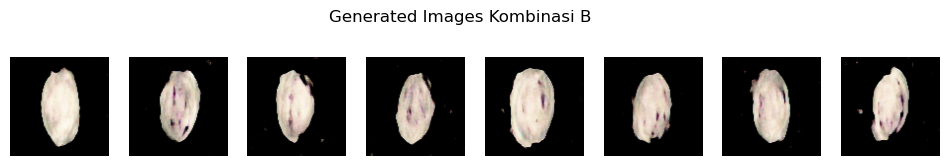

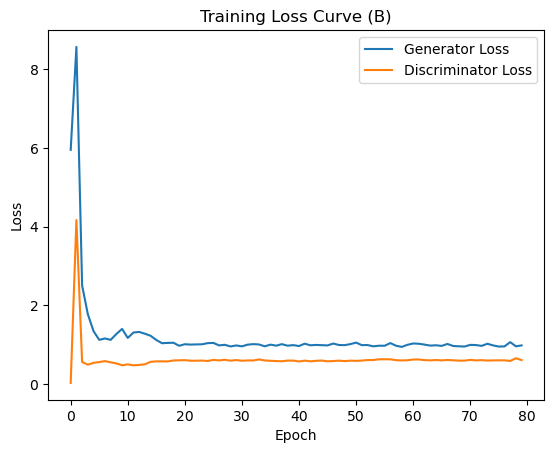

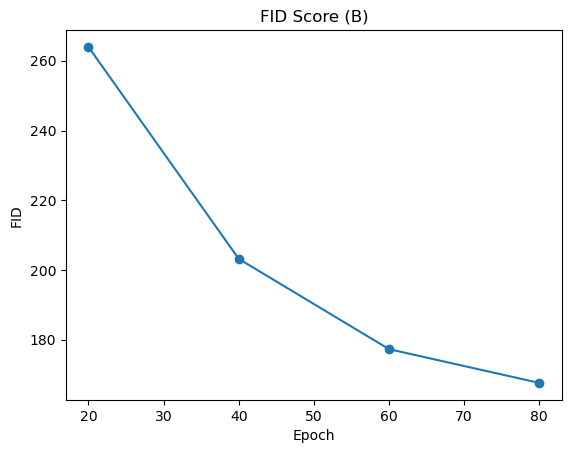

Final FID Score (B): 167.62

=== Kombinasi C | lr=0.0002 | beta1=0.7 ===


Kombinasi C:  25%|█████████████████▎                                                   | 20/80 [01:06<04:31,  4.52s/it]

FID Score (Epoch 20): 318.06536865234375


Kombinasi C:  50%|██████████████████████████████████▌                                  | 40/80 [02:14<02:58,  4.46s/it]

FID Score (Epoch 40): 231.6753387451172


Kombinasi C:  75%|███████████████████████████████████████████████████▊                 | 60/80 [03:20<01:29,  4.50s/it]

FID Score (Epoch 60): 219.64334106445312


Kombinasi C: 100%|█████████████████████████████████████████████████████████████████████| 80/80 [04:28<00:00,  3.35s/it]

FID Score (Epoch 80): 186.37045288085938


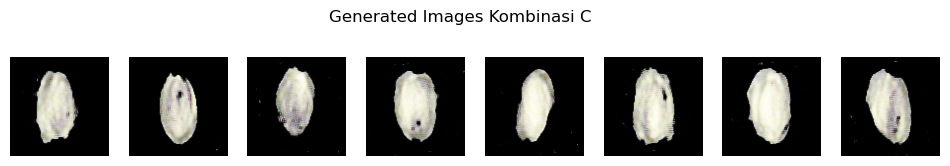

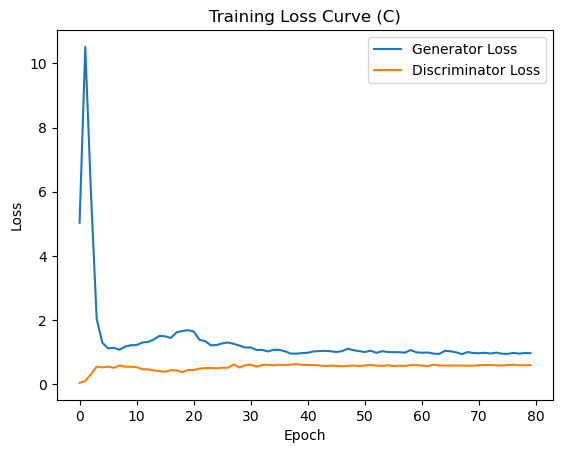

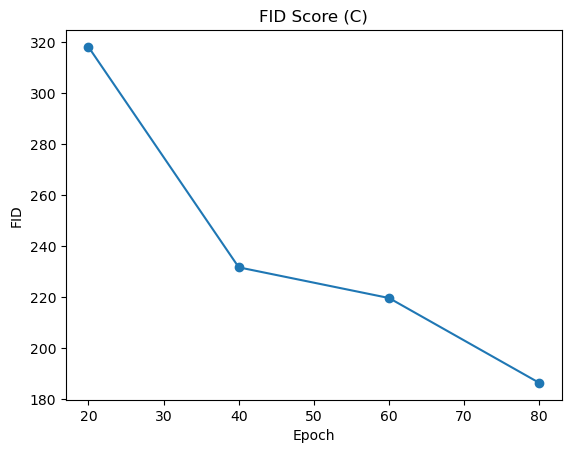

Final FID Score (C): 186.37

=== Kombinasi D | lr=0.0003 | beta1=0.7 ===


Kombinasi D:  25%|█████████████████▎                                                   | 20/80 [01:11<04:56,  4.95s/it]

FID Score (Epoch 20): 254.0194091796875


Kombinasi D:  50%|██████████████████████████████████▌                                  | 40/80 [02:24<03:17,  4.95s/it]

FID Score (Epoch 40): 238.32733154296875


Kombinasi D:  75%|███████████████████████████████████████████████████▊                 | 60/80 [03:37<01:38,  4.93s/it]

FID Score (Epoch 60): 227.6623077392578


Kombinasi D: 100%|█████████████████████████████████████████████████████████████████████| 80/80 [04:51<00:00,  3.64s/it]

FID Score (Epoch 80): 185.98086547851562


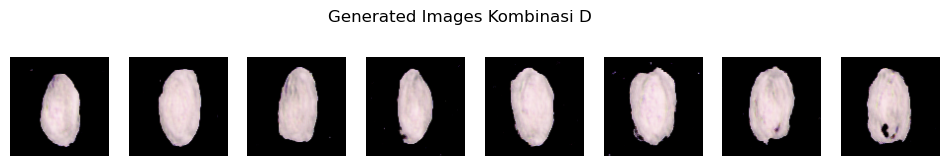

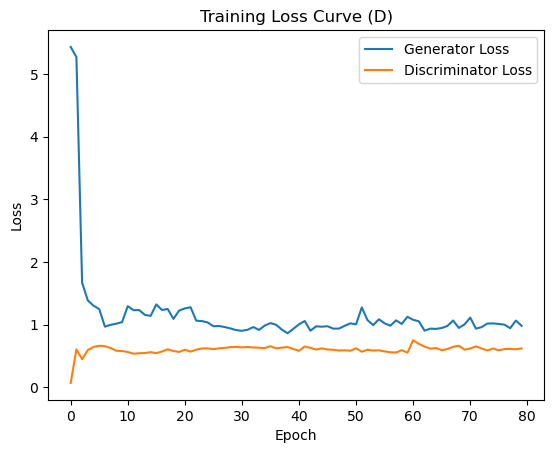

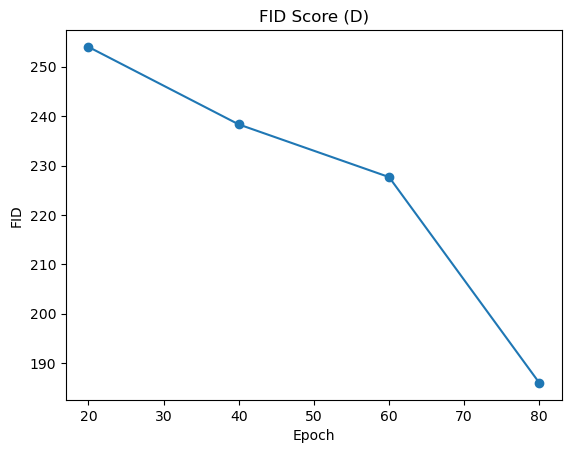

Final FID Score (D): 185.98

DONE hypertuning!


In [36]:
noise_dim = 100
epochs = 80
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results = []

for params in search_space:
    print(f"\n=== Kombinasi {params['name']} | lr={params['lr']} | beta1={params['beta1']} ===")
    # Init model
    G = Generator(noise_dim=noise_dim).to(device)
    D = Discriminator().to(device)
    optimizer_G = torch.optim.Adam(G.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))
    optimizer_D = torch.optim.Adam(D.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))
    criterion = torch.nn.BCELoss()
    losses_G, losses_D, fids, fid_epochs = [], [], [], []
    best_fid = float('inf')
    epochs_no_improve = 0
    early_stop = False

    for epoch in trange(epochs, desc=f"Kombinasi {params['name']}"):
        G.train(); D.train()
        loss_G_epoch, loss_D_epoch, n_batch = 0, 0, 0
        for real_imgs_tuple in loader:
            real_imgs = real_imgs_tuple[0].to(device)
            batch = real_imgs.size(0)
            valid = torch.ones((batch, 1), device=device)
            fake = torch.zeros((batch, 1), device=device)

            # Discriminator
            optimizer_D.zero_grad()
            d_real = D(real_imgs)
            loss_real = criterion(d_real, valid)
            z = torch.randn(batch, noise_dim, device=device)
            gen_imgs = G(z)
            d_fake = D(gen_imgs.detach())
            loss_fake = criterion(d_fake, fake)
            d_loss = (loss_real + loss_fake) / 2
            d_loss.backward()
            optimizer_D.step()

            # Generator
            optimizer_G.zero_grad()
            z = torch.randn(batch, noise_dim, device=device)
            gen_imgs = G(z)
            d_fake = D(gen_imgs)
            g_loss = criterion(d_fake, valid)
            g_loss.backward()
            optimizer_G.step()

            loss_G_epoch += g_loss.item()
            loss_D_epoch += d_loss.item()
            n_batch += 1

        loss_G_epoch /= n_batch
        loss_D_epoch /= n_batch
        losses_G.append(loss_G_epoch)
        losses_D.append(loss_D_epoch)

        # FID tiap interval
        if (epoch+1) % 20 == 0 or (epoch+1) == epochs:
            G.eval()
            fid = FrechetInceptionDistance(feature=2048).to(device)
            real_imgs_batch = images_val_torch[:100].to(device)
            with torch.no_grad():
                z = torch.randn(100, noise_dim, device=device)
                fake_imgs_batch = G(z)
            real_imgs_uint8 = ((real_imgs_batch + 1) * 127.5).clamp(0,255).to(torch.uint8)
            fake_imgs_uint8 = ((fake_imgs_batch + 1) * 127.5).clamp(0,255).to(torch.uint8)
            fid.update(real_imgs_uint8, real=True)
            fid.update(fake_imgs_uint8, real=False)
            fid_score = fid.compute().item()
            fids.append(fid_score)
            fid_epochs.append(epoch+1)
            print(f"FID Score (Epoch {epoch+1}):", fid_score)
            if fid_score < best_fid - 1e-3:
                best_fid = fid_score
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= 10:
                    print("Early stopping!")
                    early_stop = True
                    break
        if early_stop: break

    # Save result
    results.append({'params': params, 'loss_G': losses_G, 'loss_D': losses_D, 'fids': fids, 'fid_epochs': fid_epochs})

    # Visualisasi hasil akhir per kombinasi 
    G.eval()
    z = torch.randn(8, noise_dim, device=device)
    with torch.no_grad():
        fake_imgs = G(z).detach().cpu()
    fake_imgs_np = ((fake_imgs + 1.0) * 127.5).clamp(0, 255).byte().permute(0, 2, 3, 1).numpy()
    plt.figure(figsize=(12, 2))
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(fake_imgs_np[i])
        plt.axis('off')
    plt.suptitle(f'Generated Images Kombinasi {params["name"]}')
    plt.show()

    # Loss Curve 
    plt.figure()
    plt.plot(losses_G, label='Generator Loss')
    plt.plot(losses_D, label='Discriminator Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title(f'Training Loss Curve ({params["name"]})')
    plt.legend()
    plt.show()

    # FID Curve 
    plt.figure()
    plt.plot(fid_epochs, fids, marker='o')
    plt.xlabel('Epoch'); plt.ylabel('FID')
    plt.title(f'FID Score ({params["name"]})')
    plt.show()

    # Final FID 
    if len(fids) > 0:
        print(f"Final FID Score ({params['name']}): {fids[-1]:.2f}")
    else:
        print(f"FID belum dihitung.")

print("\nDONE hypertuning!")

#### Tabel Perbandingan Hasil Hypertuning GAN

| Kombinasi | lr     | beta1 | Final FID | Ciri Visual Gambar             | Catatan Training                        |
|-----------|--------|-------|-----------|--------------------------------|------------------------------------------|
| **A**     | 0.0002 | 0.5   | 187.13    | Detail visual cukup baik, tekstur cukup jelas | Loss stabil, FID turun cepat lalu stabil |
| **B**     | 0.0003 | 0.5   | 167.62    | Kualitas visual sangat baik, gambar paling halus | Loss generator paling cepat turun, FID paling rendah dan stabil |
| **C**     | 0.0002 | 0.7   | 186.37    | Sedikit blur dibanding A & B   | Loss stabil, FID turun lebih lambat      |
| **D**     | 0.0003 | 0.7   | 185.98    | Visual baik, cukup detail      | Loss stabil, FID turun signifikan di akhir training |

---

### Analisis & Kesimpulan

- **Model terbaik adalah kombinasi B** (`lr=0.0003, beta1=0.5`) dengan **FID score terendah (167.62)**. Ini menandakan kualitas gambar sintetis yang dihasilkan paling mendekati gambar asli. Kombinasi D juga cukup baik (**FID 185.98**), diikuti A dan C.
- **Visualisasi hasil generator:** Kombinasi B menghasilkan gambar pistachio yang paling halus dan konsisten secara tekstur, sedangkan C agak blur.
- **Training loss curve** semua model stabil, tidak ada tanda mode collapse, FID turun signifikan lalu flatten.
- **Parameter learning rate** terbukti paling berpengaruh terhadap konvergensi FID, sedangkan beta1 berpengaruh pada kestabilan.
- **Semua model converged tanpa overfitting** berkat early stopping berdasarkan FID.

**Rekomendasi:**  
Untuk sementara ini model **kombinasi B** sebaiknya dipilih sebagai **GAN utama** untuk sintesis data pistachio karena FID paling rendah dan visual paling baik, namun adaa baiknya tambahin epoch lagi setidaknya 200:) aku cut di 80 karena time constraint, selain itu untuk meningkatkan hasil FID bisa membuat arsitektur model Lebih Kompleks seperti **DCGAN, ResNet GAN, StyleGAN, atau UNet-based GAN**, atau menambahkan  **layer normalization** untuk memperbaiki stabilitas training, melakukan augmenrtasi pada fata training (rotasi, flip, brightness/contrast adjustment) untuk meningkatkan keragaman data dan mencegah overfitting pada pattern tertentu, tuning Hyperparameter lebih Luas misalnya Mmncoba teknik learning rate scheduling atau adaptive learning rate seperti **ReduceLROnPlateau**, melakukan **preprocessing lebih lanjut** pada data input, misalnya dengan VIF/feature selection, filtering outlier, atau advanced normalization, atau sekedar menggunakan lebih banyak data asli, atau menggabungkan data dari domain yang mirip, untuk meningkatkan kemampuan generalisasi model, dll



Link Video Penjelasan: https://drive.google.com/drive/folders/1UJiOJgqtom0NY-QWGOHSVqEmq8lLqTNF?usp=sharing